# Importando las librerías y funciones básicas

In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap


#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os


#Librería de estadística
import scipy as sp

#librería para manejo de fechas
from datetime import datetime,timedelta


# from mpl_toolkits.axes_grid1 import make_axes_locatable

#Análisis Armónico
from ttide import t_tide

plt.style.use("seaborn")
mp.rcParams['font.size'] = 18

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

# Limpieza y exploración de los datos

In [3]:
rutas = np.sort(glob.glob("../Dataset/CMEMS_ECMFW/*.nc"))

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [adt,time,lat,lon,ugos,vgos,vgosa,sla,ugosa]=reading_netcdf(rutas[i])
    else:
        [adt,time2,lat,lon,ugos,vgos,vgosa,sla2,ugosa]=reading_netcdf(rutas[i])
        sla=np.concatenate((sla,sla2))
        time=np.concatenate((time,time2))


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (367, 45, 185) m
time (367,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (367, 45, 185) m/s
vgos (367, 45, 185) m/s
vgosa (367, 45, 185) m/s
sla (367, 45, 185) m
ugosa (367, 45, 185) m/s


adt (366, 45, 185) m
tim

In [4]:
sla[sla<=-1000]=np.nan

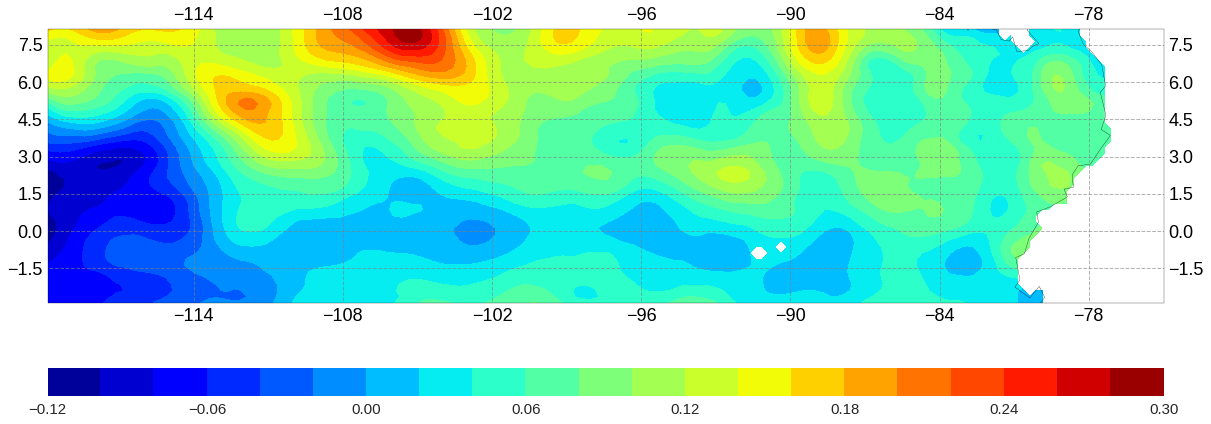

In [5]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,sla[2000,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

In [6]:
serie=np.nanmean(sla,axis=1)
serie_temp=np.nanmean(serie,axis=1)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [7]:
da=[datetime(1950,1,1,0,0,0)+timedelta(days=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)

In [8]:
serie_sla=pd.Series(serie_temp,date)

# Graficando un diagrama de Hovmoller

Un diagrama de Hovmoller permite conocer la variación temporal de una variable integrada en las latitudes o en las latitudes.

In [9]:
new_array = np.array(date.to_pydatetime(), dtype=object)

In [10]:
sla_copy=sla

Se realiza el filtrado de la información con un suavizado anual para solo captar variaciones interanuales.

In [11]:
for la in range (sla_copy.shape[1]):
    for lo in range(sla_copy.shape[2]):
        a=sla_copy[:,la,lo]
        serie_test=pd.Series(a,index=date)
        serie_rolling=serie_test.rolling(30).mean()
#         serie_rolling=serie_rolling
        sla_copy[:,la,lo]=serie_rolling.values

## Hovmoller con las longitudes

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


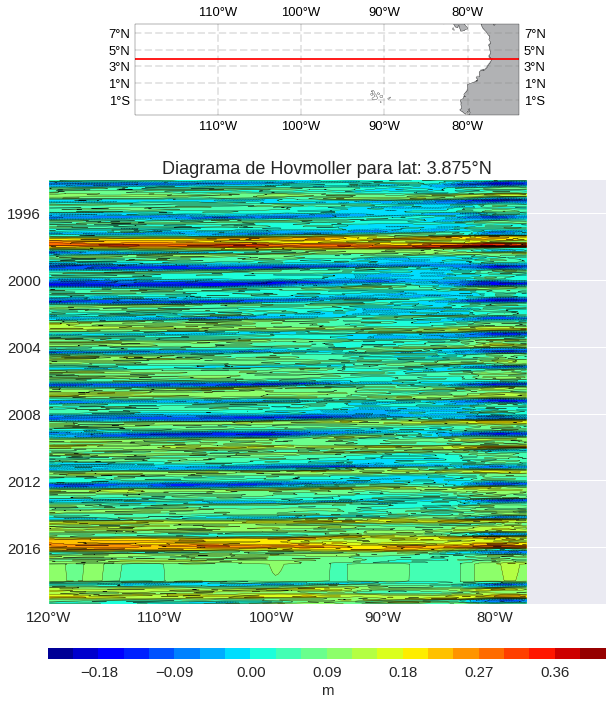

In [12]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[0],lon[-1]],[lat[27],lat[27]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(lon,new_array)
cf=ax2.contourf(x,y,sla_copy[:,27,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy[:,27,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[-1],new_array[365]))

ax2.tick_params(labelsize=15)
plt.savefig('./Plots/hovmoller_lon.png',dpi=600,bbox_inches="tight")

### Interpolando los datos a resoluciones espaciales menores.

In [13]:
new_lon=np.arange(240,286,1)
sla_copy_mod=np.zeros((sla_copy.shape[0],len(new_lon)))
for i in range(sla_copy.shape[0]):
    sla_copy_mod[i,:]=np.interp(new_lon,lon,sla_copy[i,27,:])

In [14]:
sla_copy_mod.shape

(9289, 46)

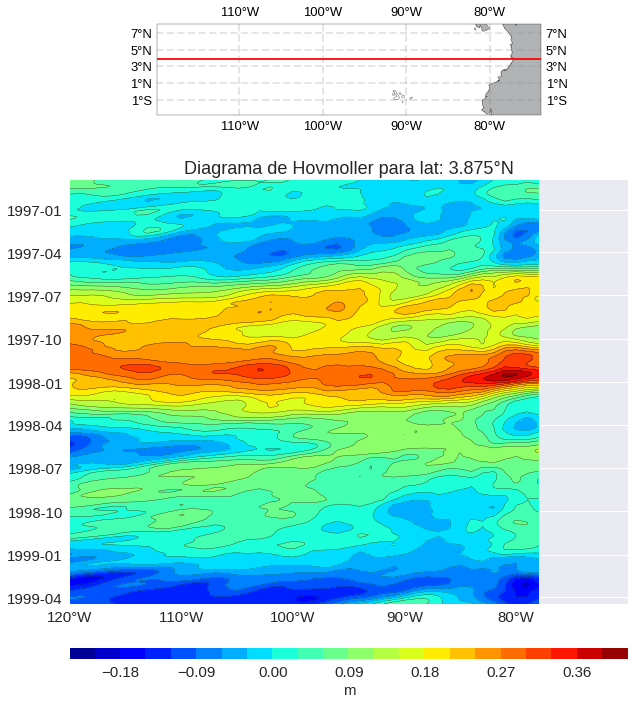

In [15]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[0],lon[-1]],[lat[27],lat[27]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[2300],new_array[1400]))

ax2.tick_params(labelsize=15)
plt.savefig('./Plots/hovmoller_lon_mod.png',dpi=600,bbox_inches="tight")

**La pregunta de investigación que surgiría es: ¿Los incrementos de nivel del mar en Buenaventura (tasas altas) se han registrado antes en una mayor longitud (mar adentro)?**

## Hovmoller con las latitudes

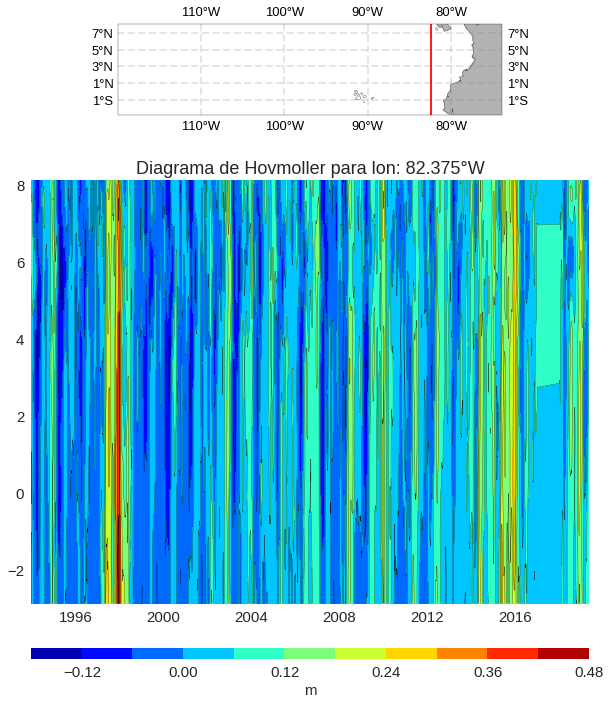

In [16]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[150],lon[150]],[lat[0],lat[-1]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title('Diagrama de Hovmoller para lon: '+str(360-lon[150])+"°W",fontsize=18)

x,y=np.meshgrid(new_array,lat)
cf=ax2.contourf(x,y,sla[:,:,150].T,10,cmap="jet")
cr=ax2.contour(x,y,sla[:,:,150].T,10,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

# ax2.set_xticks(np.array(xlocs)+360)
# ax2.set_xticklabels(x_tick_labels)
ax2.set_xlim((new_array[365],new_array[-1]))

ax2.tick_params(labelsize=15)

Revisando el diagrama de Hovmoller para las longitudes puede intuirse que si existe una zona más hacia el oeste donde también ocurren las altas tasas de nivel medio del mar que se registran en Buenaventura.

Para comparar las tasas de nivel medio del mar de 2016-2019 (zona con mayores incrementos) con otros períodos, se calculan las tasas de cambio en ventanas de 3 años

# Recopilando la información y análisis de 2019

In [17]:
fecha_inicio=datetime(1993,1,1)
# fecha_fin=datetime(2019,1,1)
fecha_fin2=datetime(2002,1,1)

## Cargue de información de nivel del mar

In [18]:
df_nmm=pd.read_csv(r"../Dataset/rqh0085a.csv")
fechas=[datetime(df_nmm.Year.loc[i],df_nmm.Month.loc[i],df_nmm.Day.loc[i],df_nmm.Hour.loc[i]) for i in range(len(df_nmm))]
serie_nmm=pd.Series(data=df_nmm.nmm.values/1000,index=fechas)
serie_nmm=serie_nmm[fecha_inicio:]

## Calculando el porcentaje de datos faltantes por año:

In [19]:
data_nmm=pd.DataFrame(serie_nmm,columns=["nmm"])
data_nmm["year"]=data_nmm.index.year
data_nmm_year=data_nmm.groupby("year").count()

In [20]:
porcentajes=np.zeros((int(len(data_nmm_year.index)),1))
for i,z in enumerate(data_nmm_year.index):
    d=(lambda year : (year % 400 == 0) or (year % 4 == 0 and year % 100 != 0))(z)
    if d==True:
        dv=366*24
        porcentajes[i]=((dv-data_nmm_year.nmm[z])/(dv))*100
    else:
        dv=365*24
        porcentajes[i]=((dv-data_nmm_year.nmm[z])/(dv))*100

In [21]:
df_faltantes=pd.DataFrame(porcentajes,index=data_nmm_year.index,columns=["Datos faltantes [%]"])

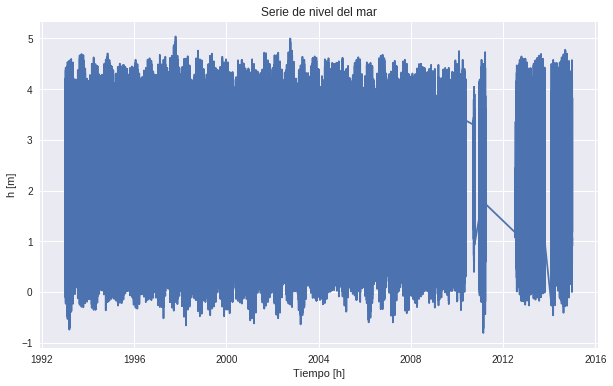

In [22]:
plt.figure(figsize=(10,6))
plt.plot(serie_nmm)
plt.title("Serie de nivel del mar")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

plt.show()

In [23]:
serie_real=serie_nmm-np.mean(serie_nmm)

## Determinación de la marea astronómica

In [24]:
def astronomica(serie_real):
    ttide=t_tide(serie_real,dt=1)
    ttide_out=ttide
    datos_astro=ttide_out["xout"].ravel()
    serie_astro=pd.Series(data=datos_astro,index=serie_real.index)
    return serie_astro

serie_astro=astronomica(serie_real[fecha_inicio:fecha_fin2])

/home/franklin/Documentos/GitHub/TDG/Scripts/ttide/t_tide.py:295: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(tc[gd, :], xin[gd])[0].T
/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/numpy/lib/type_check.py:161: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  return val.real
/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/numpy/lib/type_check.py:204: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  return val.imag


-----------------------------------
nobs = 77963 
ngood = 77963 
record length (days) = 3248.46
rayleigh criterion = 1.0

Phases at central time
x0= -0.0144  xtrend= 0
var(data)= 1.33    var(prediction)= 0.62    var(residual)= 0.71
var(prediction)/var(data) (%) = 46.6

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0773     0.011     72.67      7.54        46
* SSA   0.0002282     0.0539     0.010    307.17     10.44        27
  MSM   0.0013098     0.0012     0.007    270.66    204.31     0.026
  MM    0.0015122     0.0074     0.010     17.86     71.95      0.54
  MSF   0.0028219     0.0148     0.011    244.12     40.06       1.9
  MF    0.0030501     0.0078     0.009     34.45     76.31      0.72
  ALP1  0.0343966     0.0005     0.002     35.62    203.89     0.038
  2Q1   0.0357064     0.0003     0.003    335.75    220.93     0.019
  SIG1  0.0359087     0.0008     0.002    150.87    189

/home/franklin/Documentos/GitHub/TDG/Scripts/ttide/t_utils.py:447: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  x = np.var(out['xingd'].real, ddof=1)
/home/franklin/Documentos/GitHub/TDG/Scripts/ttide/t_utils.py:449: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  xr = np.var(out['xresgd'].real, ddof=1)


Según información recolectada, el mayor aporte a la marea lo da la componente $M_{2}$ (principal lunar), por lo tanto es semidiurno (**tiene todo el sentido del mundo**)

Aportes principales:

- $M_{2}$: Principal lunar, 150.09 cm
- $S_{2}$: Principal solar, 40.25 cm
- $N_{2}$: Lunar mayor elíptica, 31.66 cm
- $K_{2}$: Lunar-solar declinacional, 10.97 cm
- $K_{1}$: Lunar-solar diurna declinacional, 11.25 cm


EL link de la info es [Caracterización de la marea](http://www.ideam.gov.co/documents/21021/23877/Caracterizaci%C3%B3n+de+la+Marea+%282010%29.pdf/a8ed71d8-3d7f-4a88-bed5-796c542aff4f)


## Sensibilidad de la componente M2 respecto a la cantidad de información tomada

In [25]:
fecha_inicio=datetime(1993,1,1)
amps_m2=np.ones((15,1))

for i in range(0,15,1):
    ttide=t_tide(serie_real[fecha_inicio:datetime(1993+i+1,1,1)],dt=1)
    ttide_out=ttide
    idx_m2=np.where(ttide_out["nameu"]==b'M2  ')[0]
    amps=ttide_out["tidecon"][:,0]
    amp_m2=amps[idx_m2]
    amps_m2[i]=amp_m2

-----------------------------------
nobs = 8715 
ngood = 8715 
record length (days) = 363.12
rayleigh criterion = 1.0

Phases at central time
x0= -0.0135  xtrend= 0
var(data)= 1.32    var(prediction)= 0.80    var(residual)= 0.52
var(prediction)/var(data) (%) = 61.0

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SSA   0.0002282     0.0577     0.030    290.28     33.52       3.8
  MSM   0.0013098     0.0100     0.022     50.98    155.88       0.2
  MM    0.0015122     0.0132     0.024    349.06    124.58       0.3
  MSF   0.0028219     0.0272     0.026    163.95     64.08       1.1
  MF    0.0030501     0.0086     0.024    224.33    160.59      0.13
  ALP1  0.0343966     0.0010     0.003     70.74    176.78      0.11
  2Q1   0.0357064     0.0020     0.003    207.31     91.31      0.38
  SIG1  0.0359087     0.0017     0.003    309.39    130.22       0.4
  Q1    0.0372185     0.0039     0.004    162.95     59.58

-----------------------------------
nobs = 26174 
ngood = 26173 
record length (days) = 1090.58
rayleigh criterion = 1.0

Phases at central time
x0= -0.0214  xtrend= 0
var(data)= 1.32    var(prediction)= 0.48    var(residual)= 0.85
var(prediction)/var(data) (%) = 36.1

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0912     0.011     70.06      7.08        73
* SSA   0.0002282     0.0570     0.011    297.93     11.25        29
  MSM   0.0013098     0.0084     0.010    294.99     84.67      0.69
* MM    0.0015122     0.0167     0.011    234.26     42.28       2.5
* MSF   0.0028219     0.0200     0.012    226.00     34.39       2.8
  MF    0.0030501     0.0111     0.010    310.63     57.74       1.3
  ALP1  0.0343966     0.0011     0.007    305.30    251.02     0.024
  2Q1   0.0357064     0.0005     0.007    291.16    251.79    0.0058
  SIG1  0.0359087     0.0014     0.007    189.87    182

-----------------------------------
nobs = 43456 
ngood = 43455 
record length (days) = 1810.67
rayleigh criterion = 1.0

Phases at central time
x0= -0.00338  xtrend= 0
var(data)= 1.33    var(prediction)= 0.49    var(residual)= 0.84
var(prediction)/var(data) (%) = 36.9

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0892     0.011     72.63      7.00        71
* SSA   0.0002282     0.0613     0.010    297.96      9.56        38
  MSM   0.0013098     0.0014     0.006    164.93    217.80     0.049
  MM    0.0015122     0.0036     0.008    204.27    137.10      0.21
* MSF   0.0028219     0.0160     0.010    120.88     43.61       2.4
  MF    0.0030501     0.0109     0.010    206.00     58.40       1.1
  ALP1  0.0343966     0.0004     0.005    151.54    270.12     0.006
  2Q1   0.0357064     0.0003     0.005     71.53    254.27    0.0038
  SIG1  0.0359087     0.0002     0.004    359.30    24

-----------------------------------
nobs = 60976 
ngood = 60975 
record length (days) = 2540.67
rayleigh criterion = 1.0

Phases at central time
x0= -0.00804  xtrend= 0
var(data)= 1.34    var(prediction)= 0.64    var(residual)= 0.70
var(prediction)/var(data) (%) = 47.8

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0745     0.012     67.49      8.65        41
* SSA   0.0002282     0.0554     0.011    293.22     10.23        27
  MSM   0.0013098     0.0017     0.008    333.39    217.31     0.043
  MM    0.0015122     0.0035     0.009    299.90    143.05      0.16
* MSF   0.0028219     0.0183     0.012    230.15     34.73       2.4
  MF    0.0030501     0.0095     0.009    326.26     74.76       1.1
  ALP1  0.0343966     0.0002     0.003    342.41    273.12    0.0037
  2Q1   0.0357064     0.0006     0.003     88.16    212.94     0.038
  SIG1  0.0359087     0.0005     0.003    136.36    20

-----------------------------------
nobs = 77963 
ngood = 77963 
record length (days) = 3248.46
rayleigh criterion = 1.0

Phases at central time
x0= -0.0144  xtrend= 0
var(data)= 1.33    var(prediction)= 0.62    var(residual)= 0.71
var(prediction)/var(data) (%) = 46.6

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0773     0.011     72.67      7.50        51
* SSA   0.0002282     0.0539     0.009    307.17     10.95        33
  MSM   0.0013098     0.0012     0.007    270.66    239.40     0.026
  MM    0.0015122     0.0074     0.009     17.86     83.55      0.69
* MSF   0.0028219     0.0148     0.010    244.12     36.75       2.4
  MF    0.0030501     0.0078     0.010     34.45     79.94      0.63
  ALP1  0.0343966     0.0005     0.002     35.62    218.45     0.043
  2Q1   0.0357064     0.0003     0.002    335.75    257.38     0.028
  SIG1  0.0359087     0.0008     0.002    150.87    202

-----------------------------------
nobs = 95215 
ngood = 95215 
record length (days) = 3967.29
rayleigh criterion = 1.0

Phases at central time
x0= -0.00955  xtrend= 0
var(data)= 1.33    var(prediction)= 0.44    var(residual)= 0.88
var(prediction)/var(data) (%) = 33.5

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0806     0.009     76.84      6.85        88
* SSA   0.0002282     0.0517     0.009    310.09      9.84        32
  MSM   0.0013098     0.0012     0.007    256.57    201.55     0.026
  MM    0.0015122     0.0109     0.009      4.23     47.48       1.6
* MSF   0.0028219     0.0122     0.008    128.64     43.68       2.1
  MF    0.0030501     0.0090     0.009    294.06     52.44      0.98
  ALP1  0.0343966     0.0005     0.003    132.01    230.50     0.029
  2Q1   0.0357064     0.0003     0.003    312.20    232.37     0.012
  SIG1  0.0359087     0.0008     0.003    220.34    18

-----------------------------------
nobs = 110588 
ngood = 110587 
record length (days) = 4607.83
rayleigh criterion = 1.0

Phases at central time
x0= -0.0065  xtrend= 0
var(data)= 1.32    var(prediction)= 0.40    var(residual)= 0.92
var(prediction)/var(data) (%) = 30.1

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0736     0.008    112.67      7.22        84
* SSA   0.0002282     0.0410     0.009     30.37     11.33        23
  MSM   0.0013098     0.0010     0.006    138.21    214.59     0.029
  MM    0.0015122     0.0084     0.008    139.21     54.45       1.1
  MSF   0.0028219     0.0090     0.008    242.79     52.51       1.3
  MF    0.0030501     0.0085     0.009    134.99     58.88      0.92
  ALP1  0.0343966     0.0009     0.003      7.89    192.56     0.089
  2Q1   0.0357064     0.0006     0.003    170.50    202.70     0.039
  SIG1  0.0359087     0.0007     0.003    266.61    2

-----------------------------------
nobs = 127603 
ngood = 127603 
record length (days) = 5316.79
rayleigh criterion = 1.0

Phases at central time
x0= -0.0109  xtrend= 0
var(data)= 1.31    var(prediction)= 0.37    var(residual)= 0.93
var(prediction)/var(data) (%) = 28.4

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0565     0.009    112.96      9.37        42
* SSA   0.0002282     0.0322     0.008     69.38     13.61        15
  MSM   0.0013098     0.0008     0.006     60.96    244.89     0.018
  MM    0.0015122     0.0086     0.008    175.23     59.65       1.1
  MSF   0.0028219     0.0084     0.007    240.61     54.79       1.5
  MF    0.0030501     0.0083     0.009    154.78     59.04      0.81
  ALP1  0.0343966     0.0006     0.003    141.02    195.54      0.04
  2Q1   0.0357064     0.0007     0.004    267.67    207.86     0.043
  SIG1  0.0359087     0.0008     0.003    114.69    1

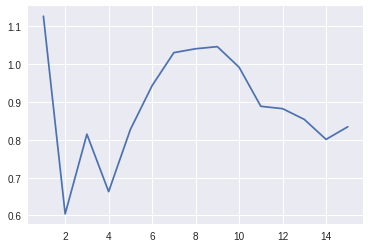

In [26]:
plt.plot(np.arange(1,16,1),amps_m2)

## Suavizado de la información

Con el fin de que la visualización de la información sea más clara y ordenada, se realiza un suavizado de cada 30 horas.

In [27]:
def smooth(y,box_pts):
    box=np.ones(box_pts)/box_pts
    y_smooth=np.convolve(y,box,mode="same")
    return y_smooth

In [28]:
def maximos(serie_real,inicio):
    maximos_real,fechas_real=[],[]
#     maximos_astro,fechas_astro=[],[]
    for k in range(int(len(serie_real)/24)):

        #Ventana de marea real
        window_real=serie_real[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
        max_window_real=np.max(window_real)

        #Ventana de marea astronómica
#         window_astro=serie_astro[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
#         max_window_astro=np.max(window_astro)

        if max_window_real>0:
#             maximos_astro.append(max_window_astro)
#             fechas_astro.append(window_astro.idxmax()-timedelta(hours=window_astro.idxmax().hour))    
            maximos_real.append(max_window_real)
            fechas_real.append(window_real.idxmax()-timedelta(hours=window_real.idxmax().hour))

    #Series de máximos
    serie_maximos_real=pd.Series(data=maximos_real,index=fechas_real)
#     serie_maximos_astro=pd.Series(data=maximos_astro,index=fechas_astro)
    return serie_maximos_real

serie_max_real=maximos(serie_real,fecha_inicio)

In [29]:
def smoothed(serie_max_real):
    serie_dif_maximos=serie_max_real
    dif_maximos_smoothed=smooth(serie_dif_maximos,30)
    serie_maximos_smoothed=pd.Series(data=dif_maximos_smoothed,index=serie_dif_maximos.index)
    return serie_dif_maximos,serie_maximos_smoothed

In [30]:
serie_dif_maximos,serie_maximos_smoothed=smoothed(serie_max_real)

Text(0.5, 0, 'Tiempo [h]')

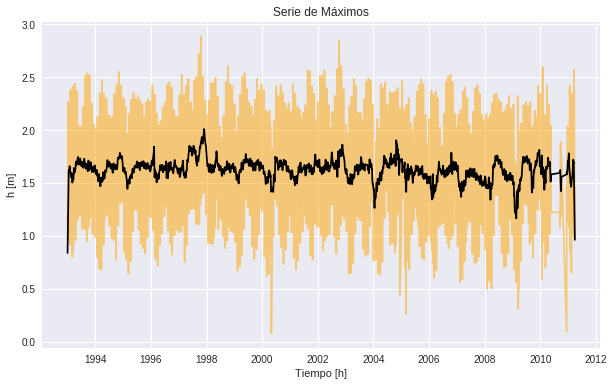

In [31]:
plt.figure(figsize=(10,6))
plt.title("Serie de Máximos")
plt.plot(serie_dif_maximos,c="orange",alpha=0.5)
plt.plot(serie_maximos_smoothed,c="k")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

## Datos y Eventos ENSO desde el índice ONI

In [32]:
dataset_oni=pd.read_excel(r"../Dataset/oni index.xlsx").set_index("Year")
# rutas = glob.glob("../Dataset/CMEMS_ECMFW/*.nc")

In [33]:
def serie_oni(dataset_oni):
    data=dataset_oni.values.ravel()
    fechas=pd.date_range("1950-01-01","2019-01-01",freq="M")
    date=[i-timedelta(days=15) for i in fechas]
    serie_oni_d=pd.Series(data=data,index=date)[fecha_inicio:]
    return serie_oni_d

In [34]:
Serie_oni=serie_oni(dataset_oni)

In [35]:
def looking_for_events(Serie_oni):
    loc_niña=[] #Revisar siempre estas posiciones
    loc_niño=[]
    for i in range (4,int(len(Serie_oni)-4)):
        k,d,z=0,0,0
        while k<5:
            a=i+k-4
            b=i+k+1
            window=np.around(np.asarray((Serie_oni.values[a:b])),1)
            test_niño=window>=0.5
            test_niña=window<=-0.5
            if test_niño.all()==True:
                d=d+1
            if test_niña.all()==True:
                z=z+1
            k=k+1
        if d>=1:
            loc_niño.append(i)
        if z>=1:
            loc_niña.append(i)
    return loc_niña,loc_niño

In [36]:
locs_niña,locs_niño=looking_for_events(Serie_oni)     

In [37]:
def events(loc_niño,loc_niña):
    fines_niña=np.where(np.diff(loc_niña)!=1)[0].tolist()+[len(loc_niña)-1]
    fines_niño=np.where(np.diff(loc_niño)!=1)[0].tolist()+[len(loc_niño)-1]
    inicios_niña=[0]+[i+1 for i in fines_niña][:-1]
    inicios_niño=[0]+[i+1 for i in fines_niño][:-1]
    return inicios_niño,fines_niño,inicios_niña,fines_niña

In [38]:
inicio_niño,fin_niño,inicio_niña,fin_niña=events(locs_niño,locs_niña)

In [39]:
def plotting_events(Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    ax.plot(Serie_oni,'-o',c='k')
    ax.set_title("Eventos ENSO")
    ax.set_yticks(np.arange(-3,3,0.5))
    ax.grid()
    for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
    for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
    plt.grid()
    plt.savefig(".\Plots\Eventos_ENSO.png",dpi=400,box_inches="tight")
    return fig

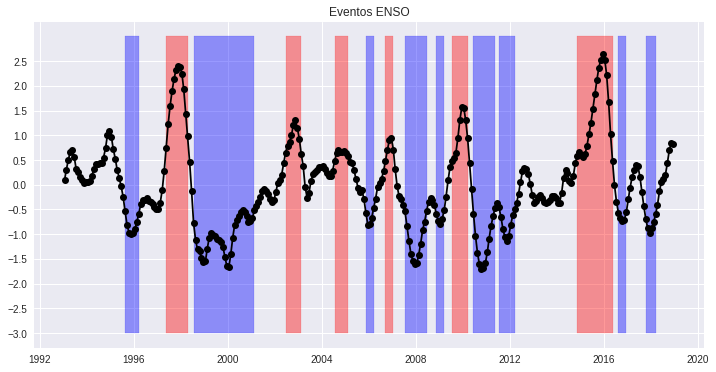

In [40]:
plots_ENSO=plotting_events(Serie_oni,inicio_niño[1:],fin_niño[1:],locs_niño,inicio_niña,fin_niña,locs_niña)

## Traslapando la información

In [41]:
def converge(serie_original,serie_smoothed,Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
        fig,ax=plt.subplots(1,1,figsize=(12,6))
#         ax.plot(serie_oni,c='red',alpha=0.5)
        ax.plot(serie_original,c='orange',alpha=0.5)
        ax.set_title("Serie de nmm vs Eventos ENSO [ONI]")
        ax.plot(serie_smoothed,c='k')
        ax.set_yticks(np.arange(-3,3,0.5))
        ax.set_ylim(0,3)
        ax.grid()
        ax.set_ylabel("h [m]")
        ax.set_xlabel("Tiempo [h]")
        for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
        for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
        plt.savefig(".\Plots\All.png",dpi=400,box_inches="tight")
        return fig

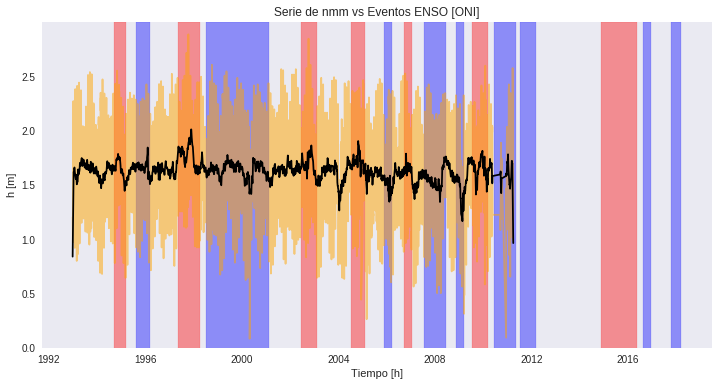

In [42]:
plot_final=converge(serie_dif_maximos,serie_maximos_smoothed,Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña)

In [43]:
rutas = glob.glob("../Dataset/CMEMS_ECMFW/*.nc")